In [1]:
import numpy as np
import pandas as pd

In [2]:
raw = pd.read_csv('onlinefraud.csv')
raw.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [3]:
raw = raw.dropna()  # one line had nan value

In [4]:
raw = raw.drop(columns=['nameOrig','nameDest']) # remove 2 useless columns

In [5]:
data = pd.get_dummies(raw, columns=['type'],drop_first=True).astype(int)

In [6]:
data = data.drop(columns=['step','isFlaggedFraud'])

In [7]:
X = data.drop('isFraud',axis=1)
y = data['isFraud']

In [8]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline  # Use imbalanced-learn's Pipeline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

# 1. First split into train/test (keeping test imbalanced)
X_train_raw, X_test, y_train_raw, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# 2. Resample ONLY the training data
pipeline = Pipeline([
    ('smote', SMOTE(sampling_strategy=0.1, random_state=42)),  # 10% fraud
    ('under', RandomUnderSampler(sampling_strategy=0.5, random_state=42))  # 50% fraud
])
X_train_bal, y_train_bal = pipeline.fit_resample(X_train_raw, y_train_raw)

# 3. Scale the resampled data (if not already done)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train_bal)  # Now X_train_sc matches y_train_bal
X_test_sc = scaler.transform(X_test)

In [13]:
X_test.columns

Index(['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest',
       'newbalanceDest', 'type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT',
       'type_TRANSFER'],
      dtype='object')

In [16]:
y_train_bal

787625     0
4799820    0
2661483    0
444747     0
609808     0
          ..
5591873    1
5591874    1
5591875    1
5591876    1
5591877    1
Name: isFraud, Length: 1525056, dtype: int32

#using X_train and y_train

In [21]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import precision_recall_curve
import numpy as np
from sklearn.preprocessing import StandardScaler
from keras.metrics import Recall

# 1. Verify and prepare data
y_train_bal = np.array(y_train_bal).astype(int)
y_test = np.array(y_test).astype(int)

print(f"Training shapes - X: {X_train_sc.shape}, y: {y_train_bal.shape}")
print(f"Test shapes - X: {X_test_sc.shape}, y: {y_test.shape}")
print(f"Class distribution - Train: {np.bincount(y_train_bal)}, Test: {np.bincount(y_test)}")

# 2. Build model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_sc.shape[1],)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# 3. Focal loss
def focal_loss(y_true, y_pred, alpha=0.25, gamma=2):
    cross_entropy = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
    modulating_factor = tf.pow(1.0 - p_t, gamma)
    return tf.reduce_mean(alpha * modulating_factor * cross_entropy)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=focal_loss,
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

# 4. Class weights
class_weight = {
    0: 1,
    1: np.sum(y_train_bal == 0) / np.sum(y_train_bal == 1)
}

# 5. Train model
history = model.fit(
    X_train_sc, y_train_bal,
    validation_data=(X_test_sc, y_test),
    class_weight=class_weight,
    epochs=100,
    batch_size=512,
    callbacks=[
        EarlyStopping(patience=10, monitor='val_recall', mode='max', restore_best_weights=True)
    ],
    verbose=1
)

# 6. Predict with fixed threshold
y_pred_proba = model.predict(X_test_sc).ravel()
threshold = 0.93
y_pred = (y_pred_proba >= threshold).astype(int)


Training shapes - X: (1525056, 9), y: (1525056,)
Test shapes - X: (1272524, 9), y: (1272524,)
Class distribution - Train: [1016704  508352], Test: [1270881    1643]


c:\Users\Abhilove Goyal\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
2979/2979 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.9135 - loss: 0.0064 - precision: 0.8780 - recall: 0.8648 - val_accuracy: 0.9949 - val_loss: 2.6828e-05 - val_precision: 0.1944 - val_recall: 0.9312
Epoch 2/100
2979/2979 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9701 - loss: 6.4133e-04 - precision: 0.9538 - recall: 0.9564 - val_accuracy: 0.9615 - val_loss: 5.5986e-04 - val_precision: 0.0324 - val_recall: 0.9970
Epoch 3/100
2979/2979 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9749 - loss: 4.6928e-04 - precision: 0.9597 - recall: 0.9653 - val_accuracy: 0.9801 - val_loss: 1.3677e-04 - val_precision: 0.0606 - val_recall: 0.9951
Epoch 4/100
2979/2979 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9769 - loss: 4.0581e-04 - precision: 0.9619 - recall: 0.9691 - val_accuracy: 0.9920 - val_loss: 3.8057e-05 - val_precision: 0.1380 - val_recall: 0.9836
Epoch 5/100
2979/2979 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9770 - loss: 4.0171e-04 - precision: 0.9616 - 

In [22]:
from sklearn.metrics import confusion_matrix
y_pred = (y_pred_proba >= 0.8).astype(int)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Non-Fraud', 'Fraud']))
matrix = confusion_matrix(y_test,y_pred)
print(matrix)


Classification Report:
              precision    recall  f1-score   support

   Non-Fraud       1.00      0.98      0.99   1270881
       Fraud       0.06      1.00      0.12      1643

    accuracy                           0.98   1272524
   macro avg       0.53      0.99      0.56   1272524
weighted avg       1.00      0.98      0.99   1272524

[[1247221   23660]
 [      6    1637]]


In [ ]:
# # Save the model in HDF5 format
# model.save("ann_model.h5")

# # Optional: Save the scaler too if you plan to use this model later
# import joblib
# joblib.dump(scaler, "scaler.save")


['scaler.save']

#Creating RF

In [39]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=20,random_state=42)
scores = cross_val_score(rf, X_train_sc, y_train_bal, scoring='f1', cv=5)
print("F1 CV Score:", scores.mean())


F1 CV Score: 0.998065627329531


In [40]:
# Compare with test set performance
from sklearn.metrics import f1_score
test_f1 = f1_score(y_test, y_pred)
print(f"Test F1: {test_f1:.3f} vs CV F1: {0.998:.3f}")

Test F1: 0.122 vs CV F1: 0.998


In [35]:
# import joblib
# joblib.dump(rf, "rf_fraud.joblib")

rf_model = joblib.load("models/rf_fraud_detector.joblib")


c:\Users\Abhilove Goyal\anaconda3\Lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.6.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


ValueError: node array from the pickle has an incompatible dtype:
- expected: [('left_child', '<i8'), ('right_child', '<i8'), ('feature', '<i8'), ('threshold', '<f8'), ('impurity', '<f8'), ('n_node_samples', '<i8'), ('weighted_n_node_samples', '<f8')]
- got     : {'names': ['left_child', 'right_child', 'feature', 'threshold', 'impurity', 'n_node_samples', 'weighted_n_node_samples', 'missing_go_to_left'], 'formats': ['<i8', '<i8', '<i8', '<f8', '<f8', '<i8', '<f8', 'u1'], 'offsets': [0, 8, 16, 24, 32, 40, 48, 56], 'itemsize': 64}

In [32]:
from sklearn.metrics import precision_recall_curve

# Get probabilities
y_probs_rf = rf.predict_proba(X_test)[:,1]

# Find threshold for 85% recall
precision, recall, thresholds = precision_recall_curve(y_test, y_probs_rf)
target_recall = 0.85
optimal_idx = np.argmax(recall >= target_recall)
optimal_threshold_rf = thresholds[optimal_idx]

# Apply threshold
y_pred_tuned = (y_probs_rf >= 0.90).astype(int)

c:\Users\Abhilove Goyal\anaconda3\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Classification Report:


c:\Users\Abhilove Goyal\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Abhilove Goyal\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Abhilove Goyal\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.00      0.00      0.00      1643

    accuracy                           1.00   1272524
   macro avg       0.50      0.50      0.50   1272524
weighted avg       1.00      1.00      1.00   1272524


Confusion Matrix:
[[1270881       0]
 [   1643       0]]


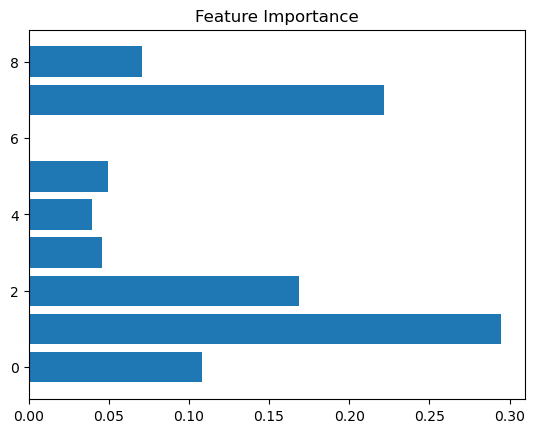

In [33]:
import matplotlib.pyplot as plt
print("Classification Report:")
print(classification_report(y_test, y_pred_tuned))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_tuned))

# Feature Importance
importances = rf.feature_importances_
plt.barh(range(X_train_sc.shape[1]), importances)
plt.title("Feature Importance")
plt.show()

#META MODEL

In [ ]:
# Your current ANN (keep threshold=0.9)
ann_recall_probs = model.predict(X_test_sc).ravel()
ann_preds = (ann_recall_probs >= 0.9).astype(int)  # 88% recall

from sklearn.ensemble import RandomForestClassifier

# Train RF to maximize precision
rf = RandomForestClassifier(
    class_weight={0:1, 1:100},  # Heavy penalty for missing fraud
    max_depth=5,                # Prevent overfitting
    n_estimators=200,
    random_state=42
)
rf.fit(X_train_sc, y_train_bal)

# Get RF probabilities (for precision)
rf_precision_probs = rf.predict_proba(X_test_sc)[:, 1]
rf_preds = (rf_precision_probs >= 0.95).astype(int)  # High threshold

5456/5456 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step


In [ ]:
# Only flag as fraud if BOTH models agree
ensemble_preds = np.logical_and(ann_preds == 1, rf_preds == 1).astype(int)

In [ ]:
# Combine probabilities (adjust weights as needed)
combined_probs = 0.7*ann_recall_probs + 0.3*rf_precision_probs
ensemble_preds = (combined_probs >= 0.5).astype(int)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# 1. First split: Train vs (Validation + Test)
X_train_main, X_val_test, y_train_main, y_val_test = train_test_split(
    X_train_sc, y_train_bal, test_size=0.4, random_state=42
)

# 2. Second split: Validation vs Test
X_val, X_test, y_val, y_test = train_test_split(
    X_val_test, y_val_test, test_size=0.5, random_state=42
)

# 3. Train base models on MAIN training set
model.fit(X_train_main, y_train_main)
rf.fit(X_train_main, y_train_main)

# 4. Generate level-1 features (VAL set)
X_level1 = np.column_stack([
    model.predict(X_val).ravel(),  # ANN predictions
    rf.predict_proba(X_val)[:, 1]     # RF probabilities
])

# 5. Train meta-model on validation predictions
meta_model = LogisticRegression(class_weight={0:1, 1:50})
meta_model.fit(X_level1, y_val)

# 6. Generate test predictions (NO LEAKAGE)
X_test_level1 = np.column_stack([
    model.predict(X_test).ravel(),
    rf.predict_proba(X_test)[:, 1]
])
ensemble_preds = meta_model.predict(X_test_level1)

# 7. Evaluate
print(classification_report(y_test, ensemble_preds))

3926/3926 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.9100 - loss: 0.0041 - precision: 0.8813 - recall: 0.8404
1309/1309 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1309/1309 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
              precision    recall  f1-score   support

           0       1.00      0.83      0.91     27872
           1       0.75      1.00      0.86     14002

    accuracy                           0.89     41874
   macro avg       0.87      0.92      0.88     41874
weighted avg       0.92      0.89      0.89     41874

